In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

## tf_keras_model.py

In [ ]:
# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='average', name='edgeconv'):
    """EdgeConv
    Args:
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K)

        fts = features
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C)
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C)

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _particle_net_base(points, features=None, mask=None, setting=None, name='particle_net'):
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optinal

    with tf.name_scope(name):
        if features is None:
            features = points

        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99

        fts = tf.squeeze(keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)), axis=2)
        for layer_idx, layer_param in enumerate(setting.conv_params):
            K, channels = layer_param
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))

        if mask is not None:
            fts = tf.multiply(fts, mask)

        pool = tf.reduce_mean(fts, axis=1)  # (N, C)

        if setting.fc_params is not None:
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='softmax')(x)
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass


def get_particle_net(num_classes, input_shapes):
    r"""ParticleNet model from `"ParticleNet: Jet Tagging via Particle Clouds"
    <https://arxiv.org/abs/1902.08570>`_ paper.
    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (16, (64, 64, 64)),
        (16, (128, 128, 128)),
        (16, (256, 256, 256)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(256, 0.1)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')


def get_particle_net_lite(num_classes, input_shapes):
    r"""ParticleNet-Lite model from `"ParticleNet: Jet Tagging via Particle Clouds"
    <https://arxiv.org/abs/1902.08570>`_ paper.
    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (7, (32, 32, 32)),
        (7, (64, 64, 64)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(128, 0.1)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')


```
end tf_keras_model.py
```

### Mount google drive for loading npz files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
srcDir = '/content/drive/MyDrive/data'

In [10]:
train_filename = srcDir+'/jetConstTrain_overlap.npz'
val_filename = srcDir+'/jetConstVal_overlap.npz'
test_filename = srcDir+'/jetConstTest_overlap.npz'

In [12]:
train_file = np.load(train_filename)
val_file = np.load(val_filename)
test_file = np.load(test_filename)

In [24]:
points = ['eta', 'phi']
features = ['pt', 'mass', 'thetalab', 'radiilab', 'zlab']
mask = ['pt']

In [25]:
points_array = np.stack([train_dataset2[k].squeeze() for k in points], axis=-1)
features_array = np.stack([train_dataset2[k].squeeze() for k in features], axis=-1)
mask_array = np.stack([train_dataset2[k].squeeze() for k in mask], axis=-1)

points_array_v = np.stack([val_dataset2[k].squeeze() for k in points], axis=-1)
features_array_v = np.stack([val_dataset2[k].squeeze() for k in features], axis=-1)
mask_array_v = np.stack([val_dataset2[k].squeeze() for k in mask], axis=-1)

points_array_t = np.stack([test_dataset2[k].squeeze() for k in points], axis=-1)
features_array_t = np.stack([test_dataset2[k].squeeze() for k in features], axis=-1)
mask_array_t = np.stack([test_dataset2[k].squeeze() for k in mask], axis=-1)

In [26]:
print(points_array.shape)
print(features_array.shape)
print(mask_array.shape)
print()
print(points_array_v.shape)
print(features_array_v.shape)
print(mask_array_v.shape)
print()
print(points_array_t.shape)
print(features_array_t.shape)
print(mask_array_t.shape)

(8000, 10, 2)
(8000, 10, 5)
(8000, 10, 1)

(8000, 10, 2)
(8000, 10, 5)
(8000, 10, 1)

(4000, 10, 2)
(4000, 10, 5)
(4000, 10, 1)


In [27]:
train_dataset = {'points':points_array,
                 'features':features_array,
                 'mask':mask_array,
                 'labels':train_dataset2['labels']
                }

val_dataset = {'points':points_array_v,
               'features':features_array_v,
               'mask':mask_array_v,
               'labels':val_dataset2['labels']
                }


test_dataset = {'points':points_array_t,
               'features':features_array_t,
               'mask':mask_array_t,
               'labels':test_dataset2['labels']
                }

In [31]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = train_dataset['labels'].shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset if not 'labels' in k}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [32]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [33]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2021-02-25 16:12:44,859] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 10, 1)]      0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 10, 1)]      0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 10, 1)]      0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [35]:
# Prepare model model saving directory.
import os
save_dir = '/content/drive/MyDrive/model_checkpoints/'
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint =keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)   

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

[2021-02-25 16:12:44,958] WARNING: `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [36]:
X = {k:train_dataset[k]for k in train_dataset if not 'label' in k}
Y = train_dataset['labels']

Xval = {k:val_dataset[k]for k in val_dataset if not 'label' in k}
Yval = val_dataset['labels']

Xtest = {k:test_dataset[k]for k in test_dataset if not 'label' in k}
Ytest = test_dataset['labels']

In [53]:
# train_dataset.shuffle()
model.fit(X, Y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=1, # --- train only for 1 epoch here for demonstration ---
          validation_data=(Xval, Yval),
          shuffle=True,
          callbacks=callbacks)

[2021-02-25 16:17:44,855] INFO: Learning rate: 0.001000


Train on 8000 samples, validate on 8000 samples
Epoch 1/20
Epoch 1/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0111 - accuracy: 0.9990
Epoch 00001: val_loss improved from 0.73227 to 0.65268, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 197us/sample - loss: 0.0108 - accuracy: 0.9990 - val_loss: 0.6527 - val_accuracy: 0.5000


[2021-02-25 16:17:46,435] INFO: Learning rate: 0.001000


Epoch 2/20
Epoch 2/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9994
Epoch 00002: val_loss improved from 0.65268 to 0.53679, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 195us/sample - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.5368 - val_accuracy: 0.5106


[2021-02-25 16:17:47,995] INFO: Learning rate: 0.001000


Epoch 3/20
Epoch 3/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0023 - accuracy: 0.9994
Epoch 00003: val_loss improved from 0.53679 to 0.41361, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 203us/sample - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.4136 - val_accuracy: 0.6593


[2021-02-25 16:17:49,622] INFO: Learning rate: 0.001000


Epoch 4/20
Epoch 4/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993
Epoch 00004: val_loss improved from 0.41361 to 0.31135, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 1s 185us/sample - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.3113 - val_accuracy: 0.8662


[2021-02-25 16:17:51,105] INFO: Learning rate: 0.001000


Epoch 5/20
Epoch 5/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 00005: val_loss improved from 0.31135 to 0.22848, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 199us/sample - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2285 - val_accuracy: 0.9671


[2021-02-25 16:17:52,698] INFO: Learning rate: 0.001000


Epoch 6/20
Epoch 6/20
7168/8000 [=========================>....] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997
Epoch 00006: val_loss improved from 0.22848 to 0.16568, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 209us/sample - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.1657 - val_accuracy: 0.9936


[2021-02-25 16:17:54,371] INFO: Learning rate: 0.001000


Epoch 7/20
Epoch 7/20
7168/8000 [=========================>....] - ETA: 0s - loss: 7.5633e-04 - accuracy: 0.9999
Epoch 00007: val_loss improved from 0.16568 to 0.11904, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 204us/sample - loss: 8.2265e-04 - accuracy: 0.9999 - val_loss: 0.1190 - val_accuracy: 0.9991


[2021-02-25 16:17:56,008] INFO: Learning rate: 0.001000


Epoch 8/20
Epoch 8/20
7168/8000 [=========================>....] - ETA: 0s - loss: 7.7067e-04 - accuracy: 0.9999
Epoch 00008: val_loss improved from 0.11904 to 0.08618, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 197us/sample - loss: 7.4276e-04 - accuracy: 0.9999 - val_loss: 0.0862 - val_accuracy: 0.9998


[2021-02-25 16:17:57,585] INFO: Learning rate: 0.001000


Epoch 9/20
Epoch 9/20
7168/8000 [=========================>....] - ETA: 0s - loss: 6.6496e-04 - accuracy: 0.9999
Epoch 00009: val_loss improved from 0.08618 to 0.06422, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 193us/sample - loss: 7.1115e-04 - accuracy: 0.9999 - val_loss: 0.0642 - val_accuracy: 0.9999


[2021-02-25 16:17:59,136] INFO: Learning rate: 0.001000


Epoch 10/20
Epoch 10/20
7168/8000 [=========================>....] - ETA: 0s - loss: 5.9245e-04 - accuracy: 1.0000
Epoch 00010: val_loss improved from 0.06422 to 0.04987, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 206us/sample - loss: 5.8624e-04 - accuracy: 1.0000 - val_loss: 0.0499 - val_accuracy: 0.9995


[2021-02-25 16:18:00,790] INFO: Learning rate: 0.001000


Epoch 11/20
Epoch 11/20
7168/8000 [=========================>....] - ETA: 0s - loss: 4.4887e-04 - accuracy: 1.0000
Epoch 00011: val_loss improved from 0.04987 to 0.04039, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 196us/sample - loss: 4.3314e-04 - accuracy: 1.0000 - val_loss: 0.0404 - val_accuracy: 0.9994


[2021-02-25 16:18:02,365] INFO: Learning rate: 0.000100


Epoch 12/20
Epoch 12/20
7168/8000 [=========================>....] - ETA: 0s - loss: 3.9072e-04 - accuracy: 1.0000
Epoch 00012: val_loss improved from 0.04039 to 0.03530, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 206us/sample - loss: 3.9672e-04 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 0.9991


[2021-02-25 16:18:04,016] INFO: Learning rate: 0.000100


Epoch 13/20
Epoch 13/20
7168/8000 [=========================>....] - ETA: 0s - loss: 4.9522e-04 - accuracy: 1.0000
Epoch 00013: val_loss improved from 0.03530 to 0.03189, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 197us/sample - loss: 4.8060e-04 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9987


[2021-02-25 16:18:05,594] INFO: Learning rate: 0.000100


Epoch 14/20
Epoch 14/20
7168/8000 [=========================>....] - ETA: 0s - loss: 4.0438e-04 - accuracy: 1.0000
Epoch 00014: val_loss improved from 0.03189 to 0.02942, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 202us/sample - loss: 5.8010e-04 - accuracy: 0.9999 - val_loss: 0.0294 - val_accuracy: 0.9979


[2021-02-25 16:18:07,213] INFO: Learning rate: 0.000100


Epoch 15/20
Epoch 15/20
7168/8000 [=========================>....] - ETA: 0s - loss: 5.7766e-04 - accuracy: 0.9999
Epoch 00015: val_loss improved from 0.02942 to 0.02751, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 202us/sample - loss: 5.5411e-04 - accuracy: 0.9999 - val_loss: 0.0275 - val_accuracy: 0.9974


[2021-02-25 16:18:08,834] INFO: Learning rate: 0.000100


Epoch 16/20
Epoch 16/20
7168/8000 [=========================>....] - ETA: 0s - loss: 3.7654e-04 - accuracy: 1.0000
Epoch 00016: val_loss improved from 0.02751 to 0.02590, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 201us/sample - loss: 3.7972e-04 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9971


[2021-02-25 16:18:10,449] INFO: Learning rate: 0.000100


Epoch 17/20
Epoch 17/20
7168/8000 [=========================>....] - ETA: 0s - loss: 3.2743e-04 - accuracy: 1.0000
Epoch 00017: val_loss improved from 0.02590 to 0.02447, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 205us/sample - loss: 3.3694e-04 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9970


[2021-02-25 16:18:12,092] INFO: Learning rate: 0.000100


Epoch 18/20
Epoch 18/20
7168/8000 [=========================>....] - ETA: 0s - loss: 3.7970e-04 - accuracy: 1.0000
Epoch 00018: val_loss improved from 0.02447 to 0.02312, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 203us/sample - loss: 3.8256e-04 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9969


[2021-02-25 16:18:13,720] INFO: Learning rate: 0.000100


Epoch 19/20
Epoch 19/20
7168/8000 [=========================>....] - ETA: 0s - loss: 4.3742e-04 - accuracy: 1.0000
Epoch 00019: val_loss improved from 0.02312 to 0.02182, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 206us/sample - loss: 4.1969e-04 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9967


[2021-02-25 16:18:15,370] INFO: Learning rate: 0.000100


Epoch 20/20
Epoch 20/20
7168/8000 [=========================>....] - ETA: 0s - loss: 4.1560e-04 - accuracy: 1.0000
Epoch 00020: val_loss improved from 0.02182 to 0.02051, saving model to model_checkpoints/model.h5
8000/8000 [==============================] - 2s 202us/sample - loss: 4.1877e-04 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9967


In [54]:
!ls model_checkpoints

model.h5


## Load Modle

In [55]:
best_model = keras.models.load_model(filepath)
best_model.summary()
results = best_model.evaluate(Xtest, Ytest)
print(results)

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo (None, 10, 1)        0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL (None, 10, 1)        0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp (None, 10, 1)        0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

4000/4000 [==============================] - 1s 305us/sample - loss: 0.0216 - accuracy: 0.9970
[0.021632914781570433, 0.997]


## Plot ROC Curve

In [40]:

predict = best_model.predict(Xtest)
from sklearn.metrics import roc_curve, auc


In [64]:
import matplotlib.pyplot as plt

[2021-02-25 16:21:40,521] INFO: generated new fontManager


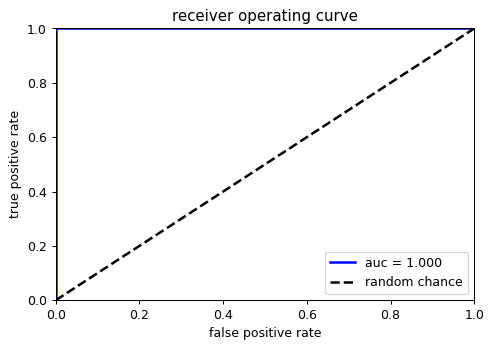

In [67]:
plt.rcParams['figure.dpi'] = 90
fpr, tpr, thresholds = roc_curve(Ytest[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
# np.savez('ROC', fpr=fpr, tpr=tpr, auc=roc_auc)
plt.show()